### Explorar los datos
***

In [38]:
# Importar librerias para manejo del dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Graficos
import seaborn as sns

# Preprocesado de datos
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Modelos de clasificación
from sklearn.ensemble import RandomForestClassifier

# Hiperparametros
from sklearn.model_selection import GridSearchCV


In [ ]:
# Leer libreria y mostrar el resultado
titanic_data = pd.read_csv('../data/train.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Leer las estadisticas
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


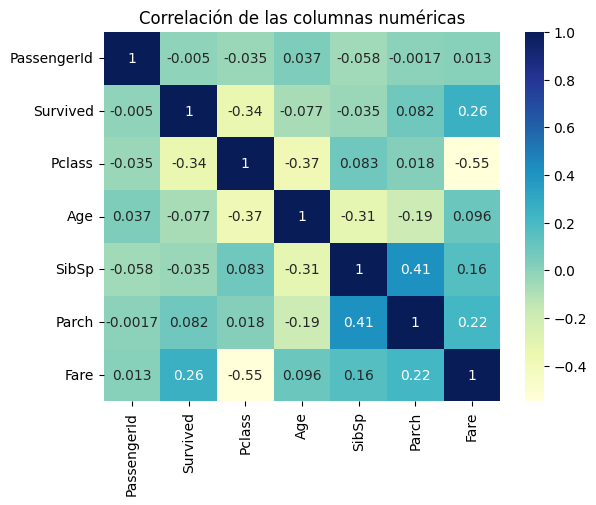

In [ ]:
# ver las Correlaciones
numeric_cols = ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
titanic_num_colum = titanic_data[numeric_cols]
sns.heatmap(titanic_num_colum.corr(), annot=True, cmap='YlGnBu').set_title('Correlación de las columnas numéricas')
plt.show()



In [22]:
# Parámetros para mezclar los datos
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Mejorar los parámetros del split de datos de entrenamiento
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

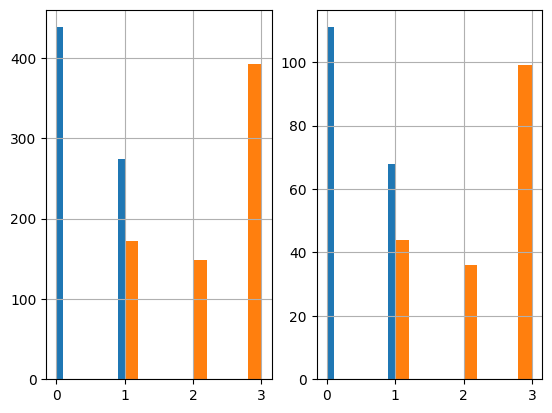

In [ ]:
# Revisar la distribución de los datos de train y test
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()

In [ ]:
# Revisar los datos de entrenamiento
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 261 to 803
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          575 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        168 non-null    object 
 11  Embarked     711 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


### PreProcesamiento de los datos
***

In [28]:
# Manejar los faltantes para edad
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy= "mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X
    
# Codificar las variables
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names = ["C", "S", "Q", "N"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        column_names = ["Female", "Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        return X
    
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors= 'ignore')


In [29]:
# Crear un pipeline
pipeline = Pipeline([
    ("ageimputer", AgeImputer()),
    ("featureencoder", FeatureEncoder()),
    ("featuredropper", FeatureDropper())
])

In [30]:
# Ejecutar pipeline a los datos de entrenamiento
strat_train_set = pipeline.fit_transform(strat_train_set)

In [34]:
# Verificamos el set de datos  de entrenamiento despues de ejecutar el pipeline
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 261 to 803
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [ ]:
# PreProcesado de los datos de entrenamiento: Escalar
X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

array([[-0.76576073,  0.82789342, -2.00869289, ...,  0.61414657,
        -0.73561236,  0.73561236],
       [ 0.79682678, -1.56828591,  1.55865408, ...,  0.61414657,
        -0.73561236,  0.73561236],
       [-0.37413478, -0.37019624, -0.0352669 , ..., -1.62827579,
        -0.73561236,  0.73561236],
       ...,
       [-1.58817521,  0.82789342, -0.6424749 , ...,  0.61414657,
        -0.73561236,  0.73561236],
       [ 0.64017641,  0.82789342, -0.1870689 , ..., -1.62827579,
        -0.73561236,  0.73561236],
       [ 1.35685188,  0.82789342, -2.20451747, ..., -1.62827579,
        -0.73561236,  0.73561236]])

### Entrenamiento de modelos
***

In [ ]:
# Definición de modelos
clf = RandomForestClassifier()

param_gird = [
    {"n_estimators": [10, 100, 200, 500], "max_depth":[None, 5, 10], "min_samples_split":[2, 3, 4]}
]

# Buscar el mejor hiperparámetro
grid_search = GridSearchCV(clf, param_gird, cv=3, scoring="accuracy", return_train_score = True)
grid_search.fit(X_data, y_data)


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [ ]:
# Imprimir el mejor Hiperparametro para el modelo
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=200)

In [ ]:
# Para hacer la mediciones de rendimiento, necesitamos procesar los datos del set también
strat_test_set = pipeline.fit_transform(strat_test_set)
strat_test_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
199,200,0,2,24.000000,0,0,13.0000,0.0,0.0,1.0,1.0,0.0
383,384,1,1,35.000000,1,0,52.0000,0.0,0.0,1.0,1.0,0.0
226,227,1,2,19.000000,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
132,133,0,3,47.000000,1,0,14.5000,0.0,0.0,1.0,1.0,0.0
749,750,0,3,31.000000,0,0,7.7500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
325,326,1,1,36.000000,0,0,135.6333,1.0,0.0,0.0,1.0,0.0
180,181,0,3,30.669065,8,2,69.5500,0.0,0.0,1.0,1.0,0.0
566,567,0,3,19.000000,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
743,744,0,3,24.000000,1,0,16.1000,0.0,0.0,1.0,0.0,1.0


In [43]:
# PreProcesado de los datos de test: Escalar
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [44]:
# Evaluacion
final_clf.score(X_data_test, y_data_test)

0.770949720670391

### Ya tenemos el modelo entrenado, ahora tenemos que ejecutar para todo el dataset
***

In [46]:
# Ejecutar el dataset completo por el pipeline
final_data = pipeline.fit_transform(titanic_data)
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [47]:
# Separar los datos para entrenamiento y test
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()

# Ejecutar el scaler
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [48]:
# Definición de modelos
prod_clf = RandomForestClassifier()

param_gird = [
    {"n_estimators": [10, 100, 200, 500], "max_depth":[None, 5, 10], "min_samples_split":[2, 3, 4]}
]

# Buscar el mejor hiperparámetro
grid_search = GridSearchCV(prod_clf, param_gird, cv=3, scoring="accuracy", return_train_score = True)
grid_search.fit(X_data_final, y_data_final)


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [49]:
# Obtener los mejores parametros
prod_final_clf = grid_search.best_estimator_
prod_final_clf

RandomForestClassifier(max_depth=5, n_estimators=10)

In [50]:
# Evaluacion
prod_final_clf.score(X_data_final, y_data_final)

0.8529741863075196

### Nuestro modelo de clasificación está listo!
Podemos ejecutar el test.csv para luego crear el gender_submision.csv
***

In [58]:
# Cargamos el dataset de prueba
titanic_test_data = pd.read_csv('../data/test.csv')
titanic_test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [59]:
# Pasamos el dataset de prueba por el pipeline
final_test_data = pipeline.fit_transform(titanic_test_data)
final_test_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [ ]:
# Preparar los datos del ultimo test para hacer las predicciones
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method='ffill')

# Escalar los datos
scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

C:\Users\asosa\AppData\Local\Temp\ipykernel_7508\1044929137.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method='ffill')


In [ ]:
# Ejecutar el modelo entrenado con los datos del test.csv para hacer predicciones
predictions = prod_final_clf.predict(X_data_final_test)

In [66]:
# Armar un CSV con el resultado
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions

# Guardar las predicciones a un archivo CSV
final_df.to_csv('../data/predictions.csv', index=False)
final_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
